# Eigenvalue dynamics for learning in a toy Siamese network with i.i.d. Gaussian inputs

This notebook reproduces the learning dynamics for the toy Siamese network with i.i.d. Gaussian inputs, shown in Figures 2, 5 and 6 in the paper.

In [1]:
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set_palette(['#44AA99', '#332288', '#882255', '#CC6677', '#88CCEE', '#117733', '#999933', '#DDCC77', '#CC6677', '#AA4499', '#EE7733', '#EE3377'])

random_seed = 2

We use two activation functions, just the identity for the linear case, and the ReLU for the nonlinear case.  The ReLU is defined as $f(x) = \max(0,x)$.

In [2]:
def idty(x):
  return x

def relu(x):
  return torch.nn.functional.relu(x)

Let's also define some helper functions that calculate the DirectPred predictor matrix from either the feedforward weights (closed-form expression assuming Gaussian i.i.d. inputs) or estimated from the network activations (empirical estimate).

In [3]:
def get_Wp(W, alpha=1.):
  lambdas, U = torch.linalg.eig(W@W.T)
  lambdas, U = lambdas.real, U.real
  Wp = U @ torch.diag(torch.pow(lambdas, alpha)) @ U.T
  return Wp

def get_Wp_from_Z(W, sigma_aug, nonlin=idty, alpha=1.):
  in_dim = W.shape[1]
  X1 = torch.randn((in_dim, 50000))
  X2 = X1 + sigma_aug*torch.randn_like(X1)
  X1 = X1 + sigma_aug*torch.randn_like(X1)
  Z1 = nonlin(W@X1)
  Z2 = nonlin(W@X2)
  corr = torch.matmul(Z1, Z2.T)/50000
  D, U = torch.linalg.eig(corr)
  D = torch.pow(torch.abs(D.real), alpha)
  U = U.real
  Wp = U @ torch.diag_embed(D) @ torch.linalg.inv(U)
  return Wp

def get_eig_vals(W):
  corr = W@W.T
  d = torch.linalg.eigvals(corr).real
  d, _ = torch.sort(d)
  return d

Finally, the function that actually runs the simulation, implementing the learning dynamics for several cases.

In [4]:
def next_W(W, sigma_aug, nonlin=idty, eta=0.001, alpha=1., setting="euc_simsiam", wd=0.):
  in_dim = W.shape[1]
  out_dim = W.shape[0]
  X1 = torch.randn((in_dim, 50000)) # [in_dim, 50000]
  X2 = X1 + sigma_aug*torch.randn_like(X1) # [in_dim, 50000]
  Z1 = nonlin(W@X1) # [out_dim, 50000]
  Z2 = nonlin(W@X2) # [out_dim, 50000]
  D, U = torch.linalg.eig(W@W.T) # [out_dim, out_dim]
  D = torch.pow(torch.abs(D.real), alpha) # [out_dim]
  U = U.real # [out_dim, out_dim]
  Wp = U @ torch.diag_embed(D) @ U.T # [out_dim, out_dim]
  Zp = Wp@Z1 # [out_dim, 50000]

  if nonlin==idty:
    nonlin_deriv = torch.ones_like(Z1) # [out_dim, 50000]
  elif nonlin==relu:
    nonlin_deriv = torch.nn.functional.relu(torch.sign(Z1)) # [out_dim, 50000]

  pred_error = (Zp-Z2) # [out_dim, 50000]
  pred_error = pred_error*nonlin_deriv # [out_dim, 50000]

  dot_prod = (Zp*Z2).sum(dim=0) # [50000]

  if setting=='euc_simsiam':
    deltaW = -eta*Wp.T@pred_error@X1.T/50000
  elif setting=='euc_simsiam_nopred':
    deltaW = -eta*(Z1-Z2)@X1.T/50000
  elif setting=='euc_simsiam_nosg':
    deltaW = -eta*(-pred_error)@(X2.T)/50000 -eta*Wp.T@pred_error@X1.T/50000
  elif setting=='euc_isoloss':
    deltaW = -eta*pred_error@X1.T/50000
  elif setting=='cos_simsiam':
    normp1 = Zp.norm(dim=0)+1e-8
    norm2 = Z2.norm(dim=0)+1e-8
    deltaW_post = eta*((Wp@Z2)/(normp1 * norm2) - ((dot_prod*(Wp@Zp))/(normp1**3 * norm2))) * nonlin_deriv # [out_dim, 50000] 
    deltaW = deltaW_post @ X1.T/50000 # [out_dim, in_dim]
  elif setting=='cos_simsiam_nopred':
    norm1 = Z1.norm(dim=0)
    norm2 = Z2.norm(dim=0)
    dot_prod = (Z1*Z2).sum(dim=0)
    deltaW_post = eta*((Z2)/(norm1 * norm2) - ((dot_prod*(Z1))/(norm1**3 * norm2))) * nonlin_deriv # [out_dim, 50000] 
    deltaW = deltaW_post @ X1.T/50000 # [out_dim, in_dim]
  elif setting=='cos_simsiam_nosg':
    normp1 = Zp.norm(dim=0)+1e-8
    norm2 = Z2.norm(dim=0)+1e-8
    deltaW_post = eta*((Wp@(Z2+Z1))/(normp1 * norm2) - ((dot_prod*(Wp@Zp+Z2))/(normp1**3 * norm2))) * nonlin_deriv # [out_dim, 50000] 
    deltaW = deltaW_post @ X1.T/50000 # [out_dim, in_dim]
  elif setting=='cos_isoloss':
    normp1 = Zp.norm(dim=0)+1e-8
    norm2 = Z2.norm(dim=0)+1e-8
    deltaW_post = eta*((Z2)/(normp1 * norm2) - ((dot_prod*(Zp))/(normp1**3 * norm2))) * nonlin_deriv # [out_dim, 50000] 
    deltaW = deltaW_post @ X1.T/50000 # [out_dim, in_dim]
  deltaW = deltaW - eta*wd*W
  return W + torch.nan_to_num(deltaW)

In [5]:
def run_sim(W, setting, learning_rate=1e-2, sigma_aug=0.1, n_samples=50, act=idty, num_steps=1500, alpha=1.0, X=None, wd=0.):
    in_dim = W.shape[1]
    out_dim = W.shape[0]
    if X is None:
        X = torch.randn(in_dim, n_samples)
    lambdas = torch.zeros(num_steps, out_dim)
    traj = torch.zeros((out_dim, n_samples, num_steps))
    lambdas[0] = get_eig_vals(W)
    traj[:, :, 0] = W@X

    for t in range(1, num_steps):
        W = next_W(W, sigma_aug=sigma_aug, nonlin=act, eta=learning_rate, alpha=alpha, setting=setting, wd=wd) 
        lambdas[t] = get_eig_vals(W)
        traj[:, :, t] = W@X
    
    return lambdas, traj

### Two neuron comparison (Figure 5) - Different fixed points for Euclidean and cosine distance

In [17]:
# SIMSIAM COSINE VS L2

n_samples = 5000
num_steps = 1500
in_dim = 6
out_dim = 2
learning_rate = 1e-2
sigma_aug = 0.1
act = idty
alpha = 1.0
low_rank_factor = 0.5
torch.manual_seed(random_seed)
X = torch.randn(in_dim, n_samples)
# pick 50 samples of highest norm
norms = torch.norm(X, dim=0)
_, idx = torch.sort(norms, descending=True)
X = X[:, idx[:20]]
n_samples = 20

setting = 'euc_simsiam'
torch.manual_seed(random_seed)
W = torch.randn(out_dim, in_dim)/4 
Ws = [W, W*2, torch.randn(out_dim, in_dim)/2]
W2 = [w.clone() for w in Ws]
lambdas_l2, traj_l2 = [], []
for w in Ws:
    lambdas, traj = run_sim(w, setting, learning_rate=learning_rate, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=num_steps, alpha=alpha, X=X)
    lambdas_l2.append(lambdas)
    traj_l2.append(traj)

setting = 'cos_simsiam'
torch.manual_seed(random_seed)
W = [w.clone() for w in W2]
lambdas_cos, traj_cos = [], []
for w in W:
    lambdas, traj = run_sim(w, setting, learning_rate=learning_rate, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=num_steps, alpha=alpha, X=X)
    lambdas_cos.append(lambdas)
    traj_cos.append(traj)

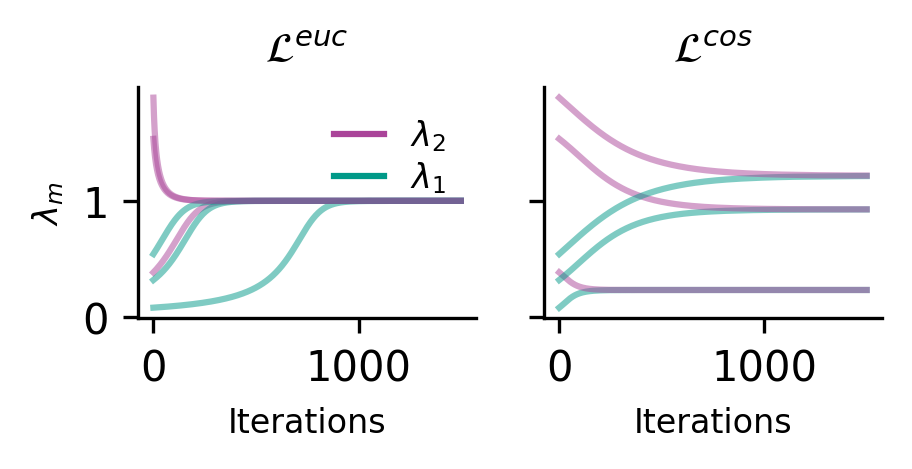

In [22]:
colors = ['#AA4499', '#009988']

fig, ax = plt.subplots(1, 2, figsize=(3.2, 1.), dpi=300, sharey=True)
for i in range(len(lambdas_l2)):
    ax[0].plot(lambdas_l2[i][:, 0], color=colors[1], label=f'$\lambda_1$', alpha=0.5)
    ax[0].plot(lambdas_l2[i][:, 1], color=colors[0], label=f'$\lambda_2$', alpha=0.5)
    ax[1].plot(lambdas_cos[i][:, 0], color=colors[1], label=f'$\lambda_1$', alpha=0.5)
    ax[1].plot(lambdas_cos[i][:, 1], color=colors[0], label=f'$\lambda_2$', alpha=0.5)
ax[0].set_xlabel('Iterations', fontsize=10)
ax[1].set_xlabel('Iterations', fontsize=10)
ax[0].set_ylabel(r'$\lambda_m$', fontsize=8)
ax[0].set_title(r'$\mathcal{L}^{euc}$', fontsize=10)
ax[1].set_title(r'$\mathcal{L}^{cos}$', fontsize=10)
custom_lines = [Line2D([0], [0], color=colors[0], lw=1.5),
                Line2D([0], [0], color=colors[1], lw=1.5)]
ax[0].legend(custom_lines, [r'$\lambda_2$', r'$\lambda_1$'], frameon=False, fontsize=8, labelspacing=0.2, loc='upper right', handlelength=1.5)
sns.despine()

### Trajectories for different settings in the linear network (Figure 2)

In [54]:
n_samples = 5000
num_steps = 1500
in_dim = 6
out_dim = 2
learning_rate = 1e-2
sigma_aug = 0.1
act = idty
alpha = 1.0
low_rank_factor = 0.5
torch.manual_seed(random_seed)
X = torch.randn(in_dim, n_samples)
# pick 50 samples of highest norm
norms = torch.norm(X, dim=0)
_, idx = torch.sort(norms, descending=True)
X = X[:, idx[:20]]
n_samples = 20
torch.manual_seed(random_seed)
W_init = torch.randn(out_dim, in_dim)/4 

settings = ['euc_simsiam', 'euc_simsiam_nosg', 'euc_simsiam_nopred', 'euc_isoloss', 'cos_simsiam', 'cos_simsiam_nosg', 'cos_simsiam_nopred', 'cos_isoloss']
trajs = []
lambdas = []
for setting in settings:
    torch.manual_seed(random_seed)
    W = W_init.clone()
    lambdas_tmp, traj_tmp = run_sim(W, setting, learning_rate=learning_rate, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=num_steps, alpha=alpha, X=X)
    lambdas.append(lambdas_tmp)
    trajs.append(traj_tmp)

In [55]:
# convert trajs to dicts of numpy arrays with keys as settings
trajs_dict = {}
for i, setting in enumerate(settings):
    trajs_dict[setting] = trajs[i]

# create a label dict with keys as settings
labels = [r'$\mathcal{L}^{euc}$', r'$\mathcal{L}^{euc}_{noSG}$', r'$\mathcal{L}^{euc}_{noPred}$', r'$\mathcal{L}^{euc}_{iso}$', r'$\mathcal{L}^{cos}$', r'$\mathcal{L}^{cos}_{noSG}$', r'$\mathcal{L}^{cos}_{noPred}$', r'$\mathcal{L}^{cos}_{iso}$']
label_dict = {}
for i, setting in enumerate(settings):
    label_dict[setting] = labels[i]

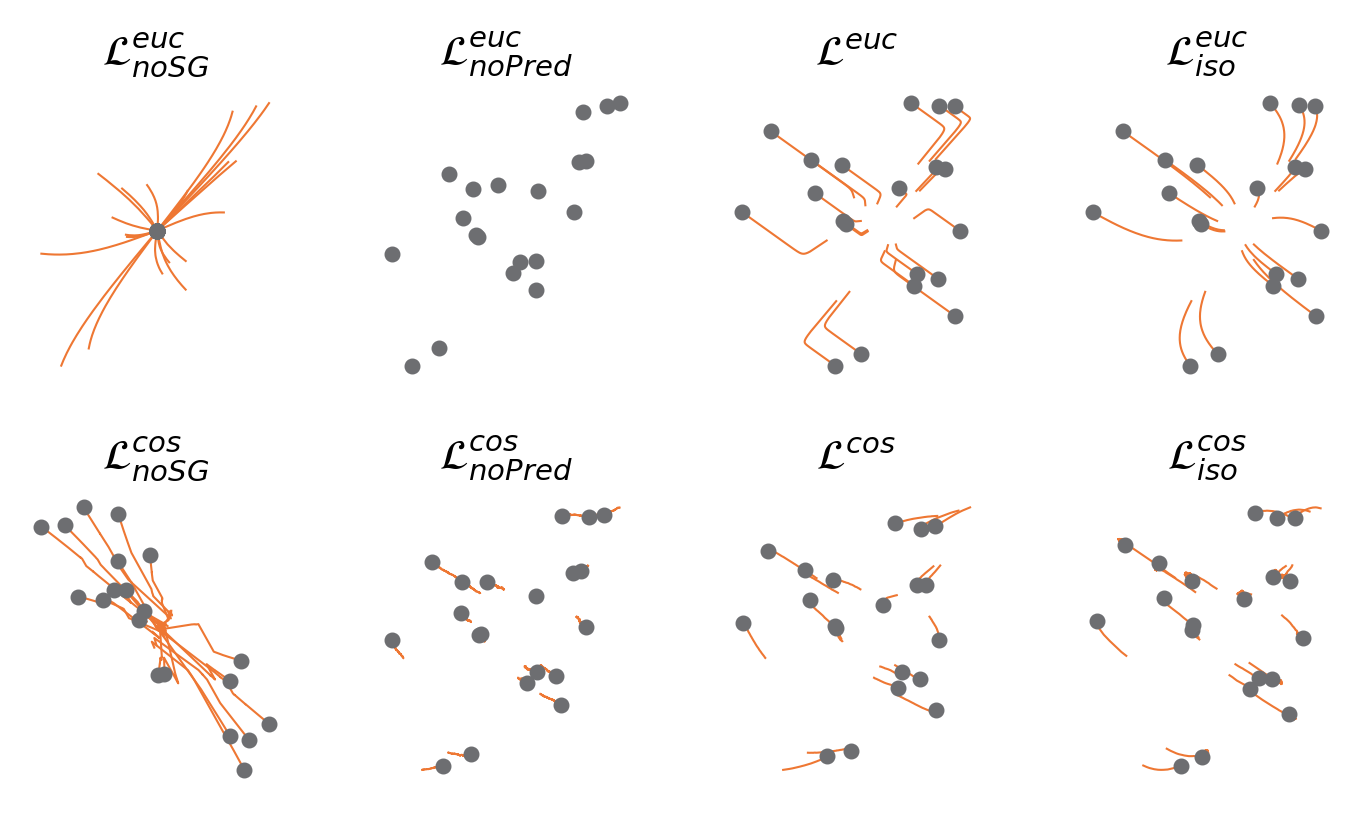

In [67]:
# plot lambdas for all settings
fig, ax = plt.subplots(2, 4, figsize=(1.4*4, 3.0), dpi=300, sharey=False)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for setting in settings:
    traj = trajs_dict[setting]
    i = 0 if 'euc' in setting else 1
    if 'nosg' in setting:
        k = 0
    elif 'nopred' in setting:
        k = 1
    elif 'isoloss' in setting:
        k = 3
    else:
        k = 2

    for j in range(n_samples):
        ax[i][k].scatter(traj[0, j, -1], traj[1, j, -1], color='#6D6E71', s=8)
        ax[i][k].plot(traj[0, j, :], traj[1, j, :], color='#EE7733', linewidth=0.5, zorder=0)
    ax[i][k].set_title(label_dict[setting], fontsize=10)
    ax[i][k].axis('off')

Note: running the following simulation can take a while, mostly because of the long training runs for the cases without a predictor. If you'd like to get a quick preview of the dynamics, you can set `num_steps_nopred` to a smaller value, e.g. 1500 or 10000.

In [26]:
n_samples = 50
num_steps = 1500
num_steps_nopred = 100000
in_dim = 15
out_dim = 10
learning_rate = 1e-2
sigma_aug = 0.1
act = idty
alpha = 1.0

torch.manual_seed(random_seed)
W_init = torch.randn(out_dim, in_dim)/4
lambdas = []

high_lr_settings = ['euc_simsiam_nopred', 'cos_simsiam', 'cos_simsiam_nosg', 'cos_simsiam_nopred', 'cos_isoloss']

for setting in settings:
    W = W_init.clone()
    lr = 0.1 if setting in high_lr_settings else learning_rate
    steps = num_steps_nopred if 'nopred' in setting else num_steps
    lambdas_tmp, traj_tmp = run_sim(W, setting, learning_rate=lr, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=steps, alpha=alpha)
    lambdas.append(lambdas_tmp)

In [27]:
# convert lambdas to dict of numpy arrays with keys as settings
lambdas_dict = {}
for i, setting in enumerate(settings):
    lambdas_dict[setting] = lambdas[i]

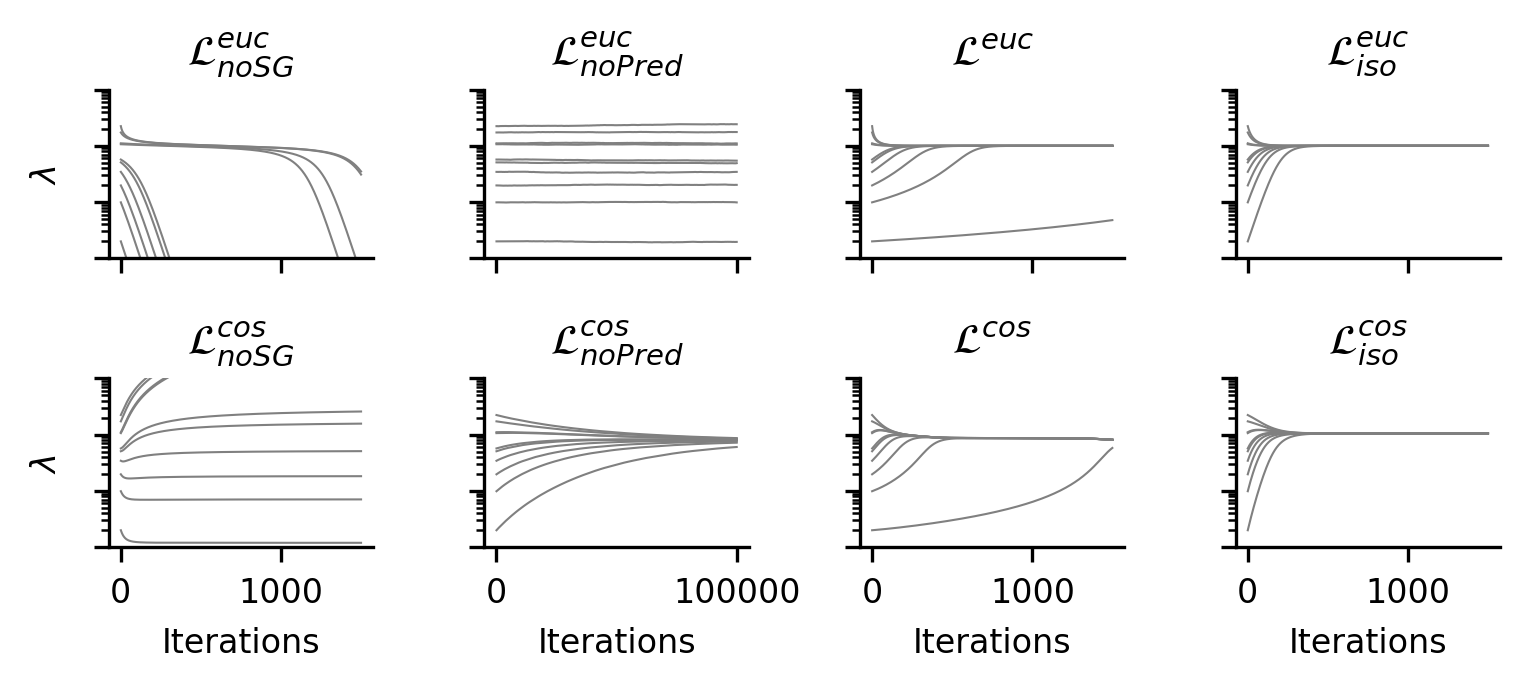

In [53]:
# plot lambdas for all settings
fig, ax = plt.subplots(2, 4, figsize=(1.3*4, 2.4), dpi=300, sharey=True)

for setting in settings:
    lambdas = lambdas_dict[setting]
    steps = np.arange(lambdas.shape[0])
    i = 0 if 'euc' in setting else 1
    if 'nosg' in setting:
        k = 0
    elif 'nopred' in setting:
        k = 1
    elif 'isoloss' in setting:
        k = 3
    else:
        k = 2

    if 'nopred' in setting:
        lambdas = lambdas[::10]
        steps = steps[::10]
    for j in range(out_dim):
        ax[i][k].semilogy(steps, lambdas[:, j], color='grey', linewidth=0.5)

    ax[i][k].set_ylim(1e-2, 10)
    ax[i][k].tick_params(axis='both', which='major', labelsize=8)
    if i == 1:
        ax[i][k].set_xlabel('Iterations', fontsize=8)
    else:
        ax[i][k].set_xticklabels([])
    if k == 0:
        ax[i][k].set_ylabel(r'$\lambda$', fontsize=8)
        ax[i][k].set_yticks([1e-1, 10])
        ax[i][k].set_yticklabels([r'$10^{-1}$', r'$10^{1}$'])
    else:
        ax[i][k].set_yticklabels([])
    ax[i][k].set_title(label_dict[setting], fontsize=10)
    sns.despine()
plt.tight_layout()

### Trajectories for different settings in the nonlinear network (Figure 6)

In [68]:
n_samples = 5000
num_steps = 1500
in_dim = 6
out_dim = 2
learning_rate = 1e-2
sigma_aug = 0.1
act = relu
alpha = 1.0
low_rank_factor = 0.5
torch.manual_seed(random_seed)
X = torch.randn(in_dim, n_samples)
# pick 50 samples of highest norm
norms = torch.norm(X, dim=0)
_, idx = torch.sort(norms, descending=True)
X = X[:, idx[:20]]
n_samples = 20
torch.manual_seed(random_seed)
W_init = torch.randn(out_dim, in_dim)/4 

settings = ['euc_simsiam', 'euc_simsiam_nosg', 'euc_simsiam_nopred', 'euc_isoloss', 'cos_simsiam', 'cos_simsiam_nosg', 'cos_simsiam_nopred', 'cos_isoloss']
trajs = []
lambdas = []
for setting in settings:
    torch.manual_seed(random_seed)
    W = W_init.clone()
    lambdas_tmp, traj_tmp = run_sim(W, setting, learning_rate=learning_rate, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=num_steps, alpha=alpha, X=X)
    lambdas.append(lambdas_tmp)
    trajs.append(traj_tmp)

In [69]:
# convert trajs to dicts of numpy arrays with keys as settings
trajs_dict = {}
for i, setting in enumerate(settings):
    trajs_dict[setting] = trajs[i]

# create a label dict with keys as settings
labels = [r'$\mathcal{L}^{euc}$', r'$\mathcal{L}^{euc}_{noSG}$', r'$\mathcal{L}^{euc}_{noPred}$', r'$\mathcal{L}^{euc}_{iso}$', r'$\mathcal{L}^{cos}$', r'$\mathcal{L}^{cos}_{noSG}$', r'$\mathcal{L}^{cos}_{noPred}$', r'$\mathcal{L}^{cos}_{iso}$']
label_dict = {}
for i, setting in enumerate(settings):
    label_dict[setting] = labels[i]

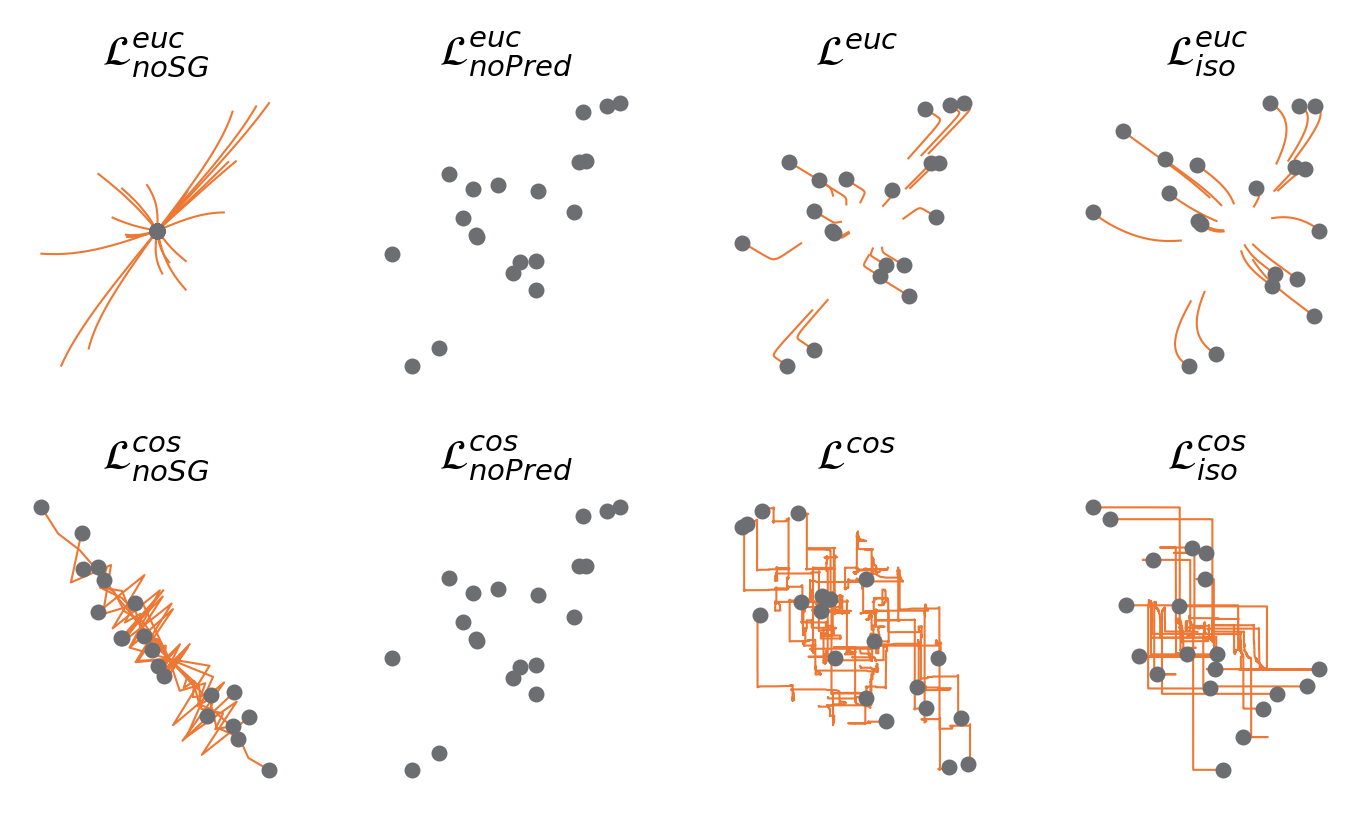

In [70]:
# plot lambdas for all settings
fig, ax = plt.subplots(2, 4, figsize=(1.4*4, 3.0), dpi=300, sharey=False)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for setting in settings:
    traj = trajs_dict[setting]
    i = 0 if 'euc' in setting else 1
    if 'nosg' in setting:
        k = 0
    elif 'nopred' in setting:
        k = 1
    elif 'isoloss' in setting:
        k = 3
    else:
        k = 2

    for j in range(n_samples):
        ax[i][k].scatter(traj[0, j, -1], traj[1, j, -1], color='#6D6E71', s=8)
        ax[i][k].plot(traj[0, j, :], traj[1, j, :], color='#EE7733', linewidth=0.5, zorder=0)
    ax[i][k].set_title(label_dict[setting], fontsize=10)
    ax[i][k].axis('off')

Again, set `num_steps_nopred` below to a smaller value for a quick simulation.

In [71]:
n_samples = 50
num_steps = 1500
num_steps_nopred = 100000
in_dim = 15
out_dim = 10
learning_rate = 1e-2
sigma_aug = 0.1
act = relu
alpha = 1.0

torch.manual_seed(random_seed)
W_init = torch.randn(out_dim, in_dim)/4
lambdas = []

high_lr_settings = ['euc_simsiam_nopred', 'cos_simsiam', 'cos_simsiam_nosg', 'cos_simsiam_nopred', 'cos_isoloss']

for setting in settings:
    W = W_init.clone()
    lr = 0.1 if setting in high_lr_settings else learning_rate
    steps = num_steps_nopred if 'nopred' in setting else num_steps
    lambdas_tmp, traj_tmp = run_sim(W, setting, learning_rate=lr, sigma_aug=sigma_aug, n_samples=n_samples, act=act, num_steps=steps, alpha=alpha)
    lambdas.append(lambdas_tmp)

In [72]:
# convert lambdas to dict of numpy arrays with keys as settings
lambdas_dict = {}
for i, setting in enumerate(settings):
    lambdas_dict[setting] = lambdas[i]

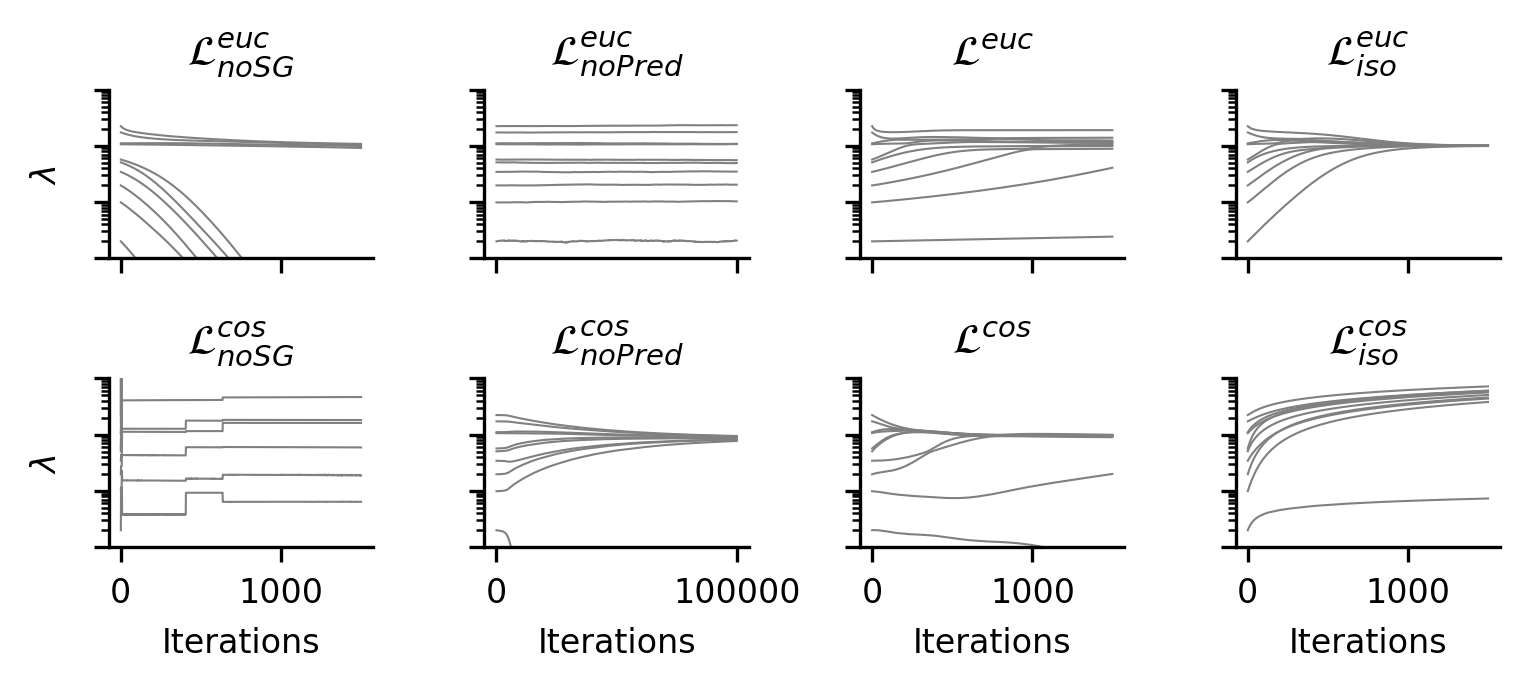

In [73]:
# plot lambdas for all settings
fig, ax = plt.subplots(2, 4, figsize=(1.3*4, 2.4), dpi=300, sharey=True)

for setting in settings:
    lambdas = lambdas_dict[setting]
    steps = np.arange(lambdas.shape[0])
    i = 0 if 'euc' in setting else 1
    if 'nosg' in setting:
        k = 0
    elif 'nopred' in setting:
        k = 1
    elif 'isoloss' in setting:
        k = 3
    else:
        k = 2

    if 'nopred' in setting:
        lambdas = lambdas[::10]
        steps = steps[::10]
    for j in range(out_dim):
        ax[i][k].semilogy(steps, lambdas[:, j], color='grey', linewidth=0.5)

    ax[i][k].set_ylim(1e-2, 10)
    ax[i][k].tick_params(axis='both', which='major', labelsize=8)
    if i == 1:
        ax[i][k].set_xlabel('Iterations', fontsize=8)
    else:
        ax[i][k].set_xticklabels([])
    if k == 0:
        ax[i][k].set_ylabel(r'$\lambda$', fontsize=8)
        ax[i][k].set_yticks([1e-1, 10])
        ax[i][k].set_yticklabels([r'$10^{-1}$', r'$10^{1}$'])
    else:
        ax[i][k].set_yticklabels([])
    ax[i][k].set_title(label_dict[setting], fontsize=10)
    sns.despine()
plt.tight_layout()